## Importing and cleaning train 

In [2]:
import pandas as pd
train= pd.read_csv('./nlp/tweets.csv', sep='^([^,]+),', engine='python', error_bad_lines=False, encoding='utf-8', index_col=[0])

In [3]:
train = train.reset_index(drop=True)

In [4]:
train.head()

,polarity,statutnull
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."


In [5]:
train.columns

Index(['polarity', 'statutnull'], dtype='object')

In [6]:
train['polarity'] = train['polarity'].str.replace("0","negatif").str.replace("4","positif")

In [7]:
index_zero = train[(train['polarity'] != 'positif') & (train['polarity']!= 'negatif')].index

In [8]:
train.drop(index_zero, inplace=True)

In [9]:
train = train.dropna()

In [10]:
train.isna().sum()

polarity      0
statutnull    0
dtype: int64

In [11]:
train.head()

,polarity,statutnull
0,negatif,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,negatif,Est contrarié qu'il ne puisse pas mettre à jou...
2,negatif,J'ai plongé plusieurs fois pour la balle. A ré...
3,negatif,Tout mon corps a des démangeaisons et comme si...
4,negatif,"Non, il ne se comporte pas du tout. je suis en..."


In [12]:
# pour test, à supprimer
train = train.sample(n=100000)

In [13]:
def clean_up(s):
    import re
    s= re.sub(r'http\S+|(www\.[^\s]+)|(@\S+)',' ',s)
    s=re.sub('[\d]',' ',s)
    s= re.sub('[^\w\s]',' ',s)
    s= re.sub('\s\s+',' ',s)
    s=s.lower().strip()
    from nltk.tokenize import word_tokenize
    s=word_tokenize(s)
    from nltk.stem.snowball import FrenchStemmer
    stemmer = FrenchStemmer()
    s = list(map(lambda x: stemmer.stem(x), s))
    from nltk.corpus import stopwords
    stop_words = stopwords.words('french')
    stop_words.append('rt')
    return [x for x in s if x not in stop_words]

In [14]:
train.statutnull = train.statutnull.astype(str).apply(lambda s: clean_up(s))

In [15]:
train.head()

,polarity,statutnull
493904,negatif,"[regard, télévis, don, manucur, détendr, rest,..."
1335693,positif,"[joyeux, anniversair]"
843625,positif,"[peut, avoir, assez]"
166751,negatif,"[accord, alor, consacr, e, tweet, fait, vais, ..."
1567069,positif,"[grosssss, tel, sueur, certain, meilleur, résu..."


In [16]:
train.rename(columns={'statutnull':'tweet'},inplace=True)

(-0.5, 799.5, 499.5, -0.5)

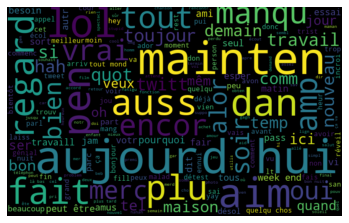

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_text= ' '.join([x for text in train.tweet for x in text])
wordcloud = WordCloud(width=800, height=500, random_state=21,max_font_size=110).generate(all_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

In [18]:
train.shape

(100000, 2)

In [19]:
#train['tweet']=' '.join(train['tweet'])
train.reset_index(drop=True).head()

,polarity,tweet
0,negatif,"[regard, télévis, don, manucur, détendr, rest,..."
1,positif,"[joyeux, anniversair]"
2,positif,"[peut, avoir, assez]"
3,negatif,"[accord, alor, consacr, e, tweet, fait, vais, ..."
4,positif,"[grosssss, tel, sueur, certain, meilleur, résu..."


In [20]:
set(train['polarity'])

{'negatif', 'positif'}

## Building model 

In [21]:
all_words = []
import nltk
NUM_FEATURES = 5000
for index, value in train.tweet.iteritems():
    if value not in all_words:
        all_words += value

top_features = [x[0] for x in nltk.FreqDist(all_words).most_common(NUM_FEATURES)]

In [22]:
df=pd.DataFrame.from_dict(nltk.FreqDist(all_words),orient='index')
df.sort_values(by=0, ascending=False).reset_index().head(10)

,index,0
0,a,11000
1,dan,6946
2,tout,6352
3,plus,5884
4,bon,5838
5,aim,5642
6,être,5348
7,mainten,5258
8,si,5258
9,bien,5071


In [23]:
def build_features(words):
    features = {}
    for w in top_features:
        features[w] = (w in words)
    return features

In [24]:
featuresets = []

for index, row in train.iterrows():
    featuresets.append((build_features(row['tweet']), row['polarity']))

In [25]:
featuresets[:2]

[({'a': False,
   'dan': False,
   'tout': False,
   'plus': False,
   'bon': False,
   'aim': False,
   'être': False,
   'mainten': False,
   'si': False,
   'bien': False,
   'fair': False,
   'jour': False,
   'fait': False,
   'aujourd': False,
   'hui': False,
   'pens': False,
   'tel': False,
   'ça': False,
   'vrai': False,
   'lol': False,
   'peux': False,
   'merc': False,
   'quelqu': False,
   'regard': True,
   'auss': False,
   'aller': False,
   'votr': False,
   'manqu': False,
   'vais': False,
   'travail': False,
   'veux': False,
   'comm': False,
   'just': False,
   'avoir': False,
   'chos': False,
   'temp': False,
   'encor': False,
   'maison': False,
   'peut': False,
   'va': False,
   'heur': False,
   'journ': False,
   'nuit': False,
   'ser': False,
   'cet': False,
   'soir': True,
   'oui': False,
   'oh': False,
   'amp': False,
   'toujour': False,
   'pass': False,
   'alor': False,
   'esper': False,
   'tres': False,
   'voir': False,
   'demai

In [26]:
from nltk import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
train_set, test = train_test_split(featuresets, test_size=0.2)
classifier = NaiveBayesClassifier.train(train_set)

In [27]:
classifier.show_most_informative_features(n=25)

Most Informative Features
                 éviscer = True           negati : positi =     32.6 : 1.0
              vétérinair = True           negati : positi =     29.9 : 1.0
             bonjournull = True           positi : negati =     26.8 : 1.0
               boulevers = True           negati : positi =     23.2 : 1.0
                  bummed = True           negati : positi =     19.6 : 1.0
                   trist = True           negati : positi =     19.5 : 1.0
               mercinull = True           positi : negati =     16.6 : 1.0
                     nul = True           negati : positi =     15.9 : 1.0
                   souri = True           positi : negati =     15.5 : 1.0
                 estomac = True           negati : positi =     15.3 : 1.0
                tristess = True           negati : positi =     15.1 : 1.0
                    agac = True           negati : positi =     15.1 : 1.0
                   déced = True           negati : positi =     15.1 : 1.0

In [28]:
import nltk
nltk.classify.accuracy(classifier, test)

0.73955

In [29]:
phrase='Je déteste la grève !'
phrase_clean=clean_up(phrase)
classifier.classify(dict([token,True] for token in phrase_clean))

'negatif'